In [32]:
import pandas as pd

data = pd.read_csv('filtered_data/mental_health_sample.txt', header=None)
data.columns=['label','text_column']

data.head()

,label,text_column
0,depression,I am writing this knowing there are many post...
1,mentalhealth,Ive been taking 20mg of Paxil since January. ...
2,mentalhealth,This happened once today for the first time I...
3,depression,Ive been suffering from depression and anxiet...
4,mentalhealth,Ive seen anhedonia but it seems like thats li...


In [33]:
data = data.groupby('label').count()

data.head()

,text_column
label,
depression,739
mentalhealth,227
mentalillness,6
socialanxiety,28


Topic: 0 
Words: 0.011*"mentioned" + 0.006*"contemplating" + 0.005*"tie" + 0.005*"medicine" + 0.005*"encouraging" + 0.003*"irrational" + 0.001*"fatal" + 0.001*"reconnect" + 0.000*"tubing" + 0.000*"cardboard"
Topic: 1 
Words: 0.038*"healthy" + 0.011*"drained" + 0.009*"somebody" + 0.007*"grief" + 0.003*"plain" + 0.002*"fragile" + 0.002*"indirectly" + 0.000*"okaynessor" + 0.000*"outward" + 0.000*"grandad"
Topic: 2 
Words: 0.000*"cling" + 0.000*"excruciatingly" + 0.000*"clawed" + 0.000*"def" + 0.000*"limp" + 0.000*"selfharmi" + 0.000*"showerso" + 0.000*"staring" + 0.000*"worksi" + 0.000*"combined"
Topic: 3 
Words: 0.017*"write" + 0.016*"attempt" + 0.012*"death" + 0.011*"date" + 0.010*"online" + 0.010*"sitting" + 0.010*"walk" + 0.010*"worry" + 0.010*"suffer" + 0.010*"appointment"
Topic: 4 
Words: 0.018*"like" + 0.017*"feel" + 0.013*"dont" + 0.012*"know" + 0.011*"want" + 0.011*"time" + 0.010*"get" + 0.010*"life" + 0.009*"year" + 0.008*"friend"
Topic: 5 
Words: 0.015*"passed" + 0.013*"lack" +

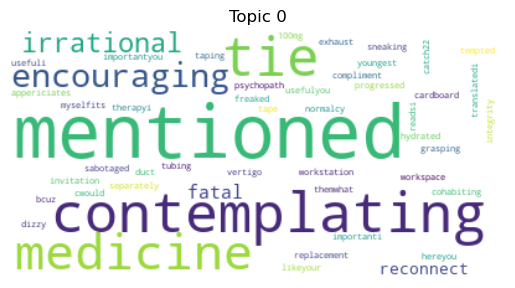

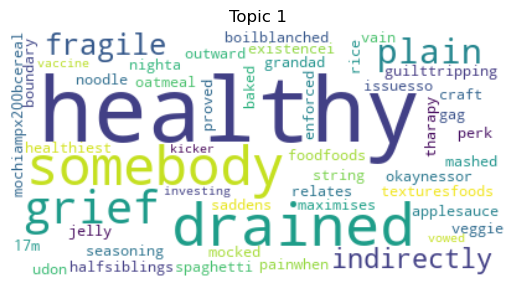

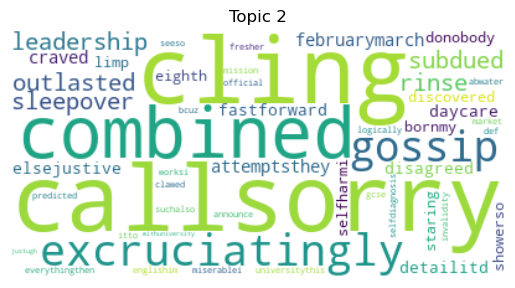

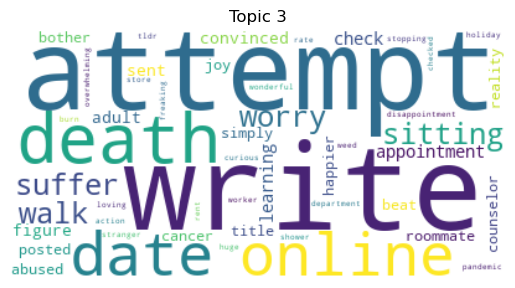

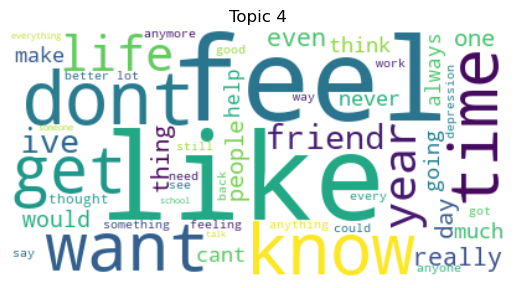

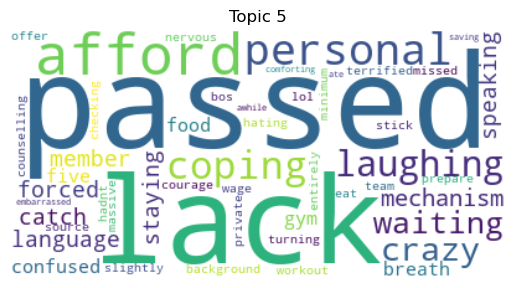

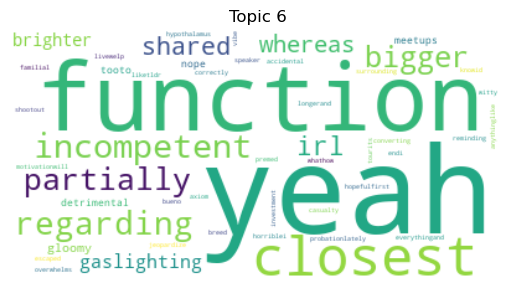

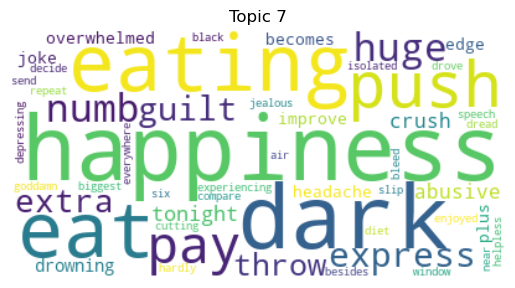

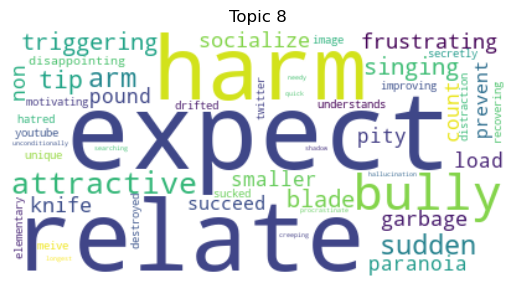

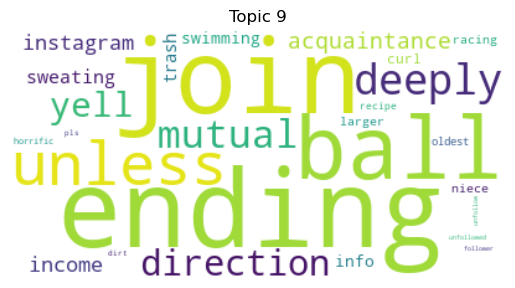

In [78]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk



stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase all words
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize words
    words = word_tokenize(text)
    # Remove stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

# Load CSV data
data = pd.read_csv('filtered_data/mental_health_sample.txt', header=None)
data.columns=['label','text_column']

documents = data['text_column'].tolist()
documents = [preprocess(doc) for doc in documents]

# Create a dictionary
dictionary = corpora.Dictionary(documents)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Train the LDA model
# lda_model = LdaModel(corpus=corpus,
#                      id2word=dictionary,
#                      num_topics=10, # Change this to the number of topics you want
# )

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=10, # Change this to the number of topics you want
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print the top topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# Create a dictionary of word frequencies for each topic
topic_word_freqs = {}
for topic_id in range(10):
    topic_word_freqs[topic_id] = dict(lda_model.show_topic(topic_id, topn=50))

# Create word clouds for each topic
for topic_id in range(10):
    wordcloud = WordCloud(background_color='white').fit_words(topic_word_freqs[topic_id])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()

#NOTE : we still need to tailor this code for our use case